In [ ]:
import tensorflow as tf
import numpy as np
import random
import os

# Check for GPU availability and set the device
if tf.config.list_physical_devices('GPU'):
    print('GPU is available. Using GPU.')
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
else:
    print('No GPU available. Using CPU.')

# Set random seeds for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

GPU is available. Using GPU.


Load the IMDb dataset, get the word index, create a reversed word index, and define a preprocessing function to clean the text. Then apply the preprocessing to the datasets and convert back to sequences.



In [ ]:
import re
import string
import pandas as pd

# Load the IMDb dataset, keeping the top 10,000 words
num_words = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=num_words)

# Get the word index dictionary
word_index = tf.keras.datasets.imdb.get_word_index()

# Create a reversed word index dictionary
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Define a preprocessing function
def preprocess_review(review_indices):
    # Convert indices back to words
    review_words = [reverse_word_index.get(i - 3, '?') for i in review_indices] # IMDb uses 0-padding, 1-start of sequence, 2-unknown. Adjust index by -3.
    review_string = ' '.join(review_words)

    # Lowercase the string
    review_string = review_string.lower()

    # Remove punctuation and special characters
    review_string = re.sub(r'[%s]' % re.escape(string.punctuation), '', review_string)
    review_string = re.sub(r'\s+', ' ', review_string).strip() # Remove extra whitespaces

    # Convert the cleaned string back into a list of words
    cleaned_words = review_string.split()

    return cleaned_words

# Apply the preprocessing function to both training and testing datasets
x_train_processed = [preprocess_review(review) for review in x_train]
x_test_processed = [preprocess_review(review) for review in x_test]

# Convert the preprocessed word lists back to sequences of word indices
def words_to_sequences(word_list, word_index, num_words):
    sequence = []
    for word in word_list:
        index = word_index.get(word)
        if index is not None and index < num_words: # Check if word is in vocabulary and within top_words
            sequence.append(index)
        else:
            sequence.append(2) # Use 2 for unknown words as per IMDb dataset convention
    return sequence

x_train_sequences = [words_to_sequences(review, word_index, num_words) for review in x_train_processed]
x_test_sequences = [words_to_sequences(review, word_index, num_words) for review in x_test_processed]

# Display the first preprocessed and sequenced review
print("Original train review (indices):", x_train[0][:20])
print("Preprocessed train review (words):", x_train_processed[0][:20])
print("Sequenced train review (indices):", x_train_sequences[0][:20])

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original train review (indices): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
Preprocessed train review (words): ['this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', 'everyones', 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you', 'could']
Sequenced train review (indices): [11, 19, 13, 40, 527, 970, 1619, 1382, 62, 455, 2, 63, 3938, 1, 170, 33, 253, 2, 22, 97]


## Prepare data for different sequence lengths

Import the necessary function and define the sequence lengths, then iterate through the lengths to pad the training and testing sequences and store them in a dictionary.



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = [25, 50, 100]
padded_sequences = {}

for length in max_len:
    padded_sequences[f'train_{length}'] = pad_sequences(x_train_sequences, maxlen=length, padding='post', truncating='post')
    padded_sequences[f'test_{length}'] = pad_sequences(x_test_sequences, maxlen=length, padding='post', truncating='post')

# Print the shapes of the padded sequences
for length in max_len:
    print(f"Shape of padded training sequences with max_len={length}: {padded_sequences[f'train_{length}'].shape}")
    print(f"Shape of padded testing sequences with max_len={length}: {padded_sequences[f'test_{length}'].shape}")

Shape of padded training sequences with max_len=25: (25000, 25)
Shape of padded testing sequences with max_len=25: (25000, 25)
Shape of padded training sequences with max_len=50: (25000, 50)
Shape of padded testing sequences with max_len=50: (25000, 50)
Shape of padded training sequences with max_len=100: (25000, 100)
Shape of padded testing sequences with max_len=100: (25000, 100)


## Define model building functions

Create functions to build RNN, LSTM, and Bidirectional LSTM models with variable activation functions, optimizers, dropout, and the option for gradient clipping.


In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

def build_model(model_type, vocabulary_size, embedding_dim, sequence_length, output_units, output_activation, optimizer_type, learning_rate, dropout_rate, clipnorm=None, clipvalue=None):
    """Builds an RNN, LSTM, or Bidirectional LSTM model.

    Args:
        model_type (str): Type of model ('RNN', 'LSTM', 'Bidirectional LSTM').
        vocabulary_size (int): The size of the vocabulary.
        embedding_dim (int): The dimension of the embedding layer.
        sequence_length (int): The maximum length of the input sequences.
        output_units (int): The number of output units in the final dense layer.
        output_activation (str): The activation function for the output layer.
        optimizer_type (str): Type of optimizer ('Adam', 'SGD', 'RMSprop').
        learning_rate (float): The learning rate for the optimizer.
        dropout_rate (float): The dropout rate.
        clipnorm (float, optional): Gradient clipping by norm. Defaults to None.
        clipvalue (float, optional): Gradient clipping by value. Defaults to None.

    Returns:
        tf.keras.models.Sequential: The compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length))

    if model_type == 'RNN':
        model.add(SimpleRNN(units=64, return_sequences=False))
    elif model_type == 'LSTM':
        model.add(LSTM(units=64, return_sequences=False))
    elif model_type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
    else:
        raise ValueError("Invalid model_type. Choose from 'RNN', 'LSTM', 'Bidirectional LSTM'.")

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=output_units, activation=output_activation))

    if optimizer_type == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_type == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer_type. Choose from 'Adam', 'SGD', 'RMSprop'.")

    if clipnorm is not None:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    elif clipvalue is not None:
         optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=clipvalue)


    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example usage (optional - for testing the function)
# vocab_size = num_words
# embedding_dim = 100
# seq_len = 100
# output_units = 1
# output_activation = 'sigmoid'
# optimizer_type = 'Adam'
# learning_rate = 0.001
# dropout_rate = 0.5

# rnn_model = build_model('RNN', vocab_size, embedding_dim, seq_len, output_units, output_activation, optimizer_type, learning_rate, dropout_rate)
# rnn_model.summary()

# lstm_model = build_model('LSTM', vocab_size, embedding_dim, seq_len, output_units, output_activation, optimizer_type, learning_rate, dropout_rate, clipnorm=1.0)
# lstm_model.summary()

# bidir_lstm_model = build_model('Bidirectional LSTM', vocab_size, embedding_dim, seq_len, output_units, output_activation, optimizer_type, learning_rate, dropout_rate, clipvalue=0.5)
# bidir_lstm_model.summary()

## Train and evaluate models

Iterate through all combinations of architecture, activation function, optimizer, sequence length, and gradient clipping strategy. For each combination:
- Build the model using the defined functions.
- Train the model on the training data for a fixed number of epochs, measuring training time per epoch.
- Evaluate the model on the test data, calculating accuracy and F1-score.
- Store the results (Model, Activation, Optimizer, Seq Length, Grad Clipping, Accuracy, F1, Epoch Time) in a structured format.
- Plot training loss vs. epochs for selected models (best and worst performing based on a chosen metric, e.g., accuracy).


Running experiment 1: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 2: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 3: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 4: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 5: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 6: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 7: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 8: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 9: Model: RNN, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 10: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 11: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 12: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 13: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 14: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 15: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 16: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 17: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 18: Model: RNN, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 19: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 20: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 21: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 22: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 23: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 24: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 25: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 26: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 27: Model: RNN, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 28: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 29: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 30: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 31: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 32: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 33: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 34: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 35: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 36: Model: RNN, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 37: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 38: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 39: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 40: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 41: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 42: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 43: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 44: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 45: Model: RNN, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 46: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 47: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 48: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 49: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 50: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 51: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 52: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 53: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 54: Model: RNN, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 55: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 56: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 57: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 58: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 59: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 60: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 61: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 62: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 63: Model: RNN, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 64: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 65: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 66: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 67: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 68: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 69: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 70: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 71: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 72: Model: RNN, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 73: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 74: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 75: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 76: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 77: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 78: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 79: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 80: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 81: Model: RNN, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 82: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 83: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 84: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 85: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 86: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 87: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 88: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 89: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 90: Model: LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 91: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 92: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 93: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 94: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 95: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 96: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 97: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 98: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 99: Model: LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 100: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 101: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 102: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 103: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 104: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 105: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 106: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 107: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 108: Model: LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 109: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 110: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 111: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 112: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 113: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 114: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 115: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 116: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 117: Model: LSTM, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 118: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 119: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 120: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 121: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 122: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 123: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 124: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 125: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 126: Model: LSTM, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 127: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 128: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 129: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 130: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 131: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 132: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 133: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 134: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 135: Model: LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 136: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 137: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 138: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 139: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 140: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 141: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 142: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 143: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 144: Model: LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 145: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 146: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 147: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 148: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 149: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 150: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 151: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 152: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 153: Model: LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 154: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 155: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 156: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 157: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 158: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 159: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 160: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 161: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 162: Model: LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 163: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 164: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 165: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 166: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 167: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 168: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 169: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 170: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 171: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 172: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 173: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 174: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 175: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 176: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 177: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 178: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 179: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 180: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 181: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 182: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 183: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 184: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 185: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 186: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 187: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 188: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 189: Model: Bidirectional LSTM, Activation: sigmoid, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 190: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 191: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 192: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 193: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 194: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 195: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 196: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 197: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 198: Model: Bidirectional LSTM, Activation: relu, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 199: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 200: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 201: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 202: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 203: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 204: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 205: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 206: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 207: Model: Bidirectional LSTM, Activation: relu, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 208: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 209: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 210: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 211: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 212: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 213: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 214: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 215: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 216: Model: Bidirectional LSTM, Activation: relu, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 217: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 218: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 219: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 220: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 221: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 222: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 223: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 224: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 225: Model: Bidirectional LSTM, Activation: tanh, Optimizer: Adam, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 226: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 227: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 228: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 229: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 230: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 231: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 232: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 233: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 234: Model: Bidirectional LSTM, Activation: tanh, Optimizer: SGD, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 235: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 236: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 237: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 25, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 238: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 239: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 240: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 50, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 241: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: none


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 242: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipnorm


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running experiment 243: Model: Bidirectional LSTM, Activation: tanh, Optimizer: RMSprop, Seq Length: 100, Grad Clipping: clipvalue


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


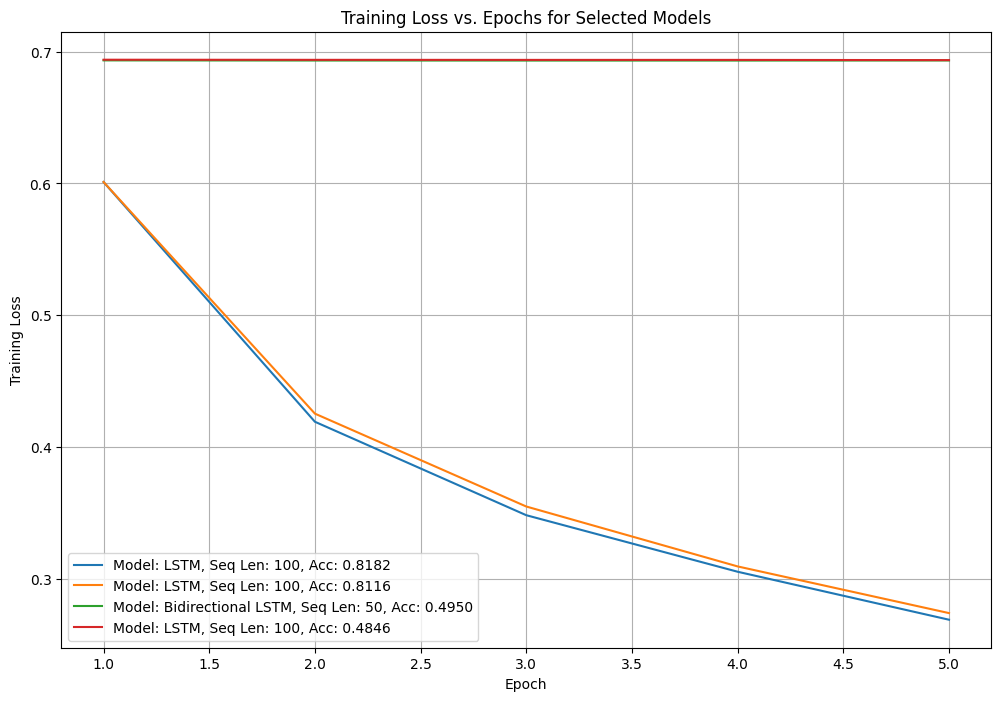

,Model,Activation,Optimizer,Seq Length,Grad Clipping,Accuracy,F1-score,Epoch Time,Training Loss History
0,RNN,sigmoid,Adam,25,none,0.66452,0.659494,4.170361,"[0.6022931933403015, 0.41873541474342346, 0.23..."
1,RNN,sigmoid,Adam,25,clipnorm,0.67148,0.667530,4.041251,"[0.613320529460907, 0.42542535066604614, 0.224..."
2,RNN,sigmoid,Adam,25,clipvalue,0.65200,0.655636,3.737162,"[0.6167030334472656, 0.4143886864185333, 0.203..."
3,RNN,sigmoid,Adam,50,none,0.54972,0.552423,4.435554,"[0.6685224771499634, 0.4731930196285248, 0.288..."
4,RNN,sigmoid,Adam,50,clipnorm,0.68608,0.644597,4.459108,"[0.6634078621864319, 0.4680512249469757, 0.292..."
...,...,...,...,...,...,...,...,...,...
238,Bidirectional LSTM,tanh,RMSprop,50,clipnorm,0.73352,0.749718,7.464981,"[0.5202011466026306, 0.36070600152015686, 0.24..."
239,Bidirectional LSTM,tanh,RMSprop,50,clipvalue,0.73852,0.751888,6.996180,"[0.520097017288208, 0.35226622223854065, 0.236..."
240,Bidirectional LSTM,tanh,RMSprop,100,none,0.76720,0.801202,7.379040,"[0.539425253868103, 0.37570154666900635, 0.316..."
241,Bidirectional LSTM,tanh,RMSprop,100,clipnorm,0.77764,0.751731,7.669000,"[0.479701429605484, 0.3139994740486145, 0.2364..."


In [ ]:
import time
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define parameter grid
parameter_grid = {
    'model_type': ['RNN', 'LSTM', 'Bidirectional LSTM'],
    'activation': ['sigmoid', 'relu', 'tanh'],
    'optimizer_type': ['Adam', 'SGD', 'RMSprop'],
    'sequence_length': [25, 50, 100],
    'gradient_clipping': ['none', 'clipnorm', 'clipvalue']
}

# Initialize list to store results
results_list = []

# Fixed training parameters
epochs = 5
embedding_dim = 100
output_units = 1
output_activation = 'sigmoid'
learning_rate = 0.001
dropout_rate = 0.5
vocabulary_size = num_words

# Iterate through all combinations
experiment_counter = 0
for model_type in parameter_grid['model_type']:
    for activation in parameter_grid['activation']:
        for optimizer_type in parameter_grid['optimizer_type']:
            for sequence_length in parameter_grid['sequence_length']:
                for gradient_clipping in parameter_grid['gradient_clipping']:
                    experiment_counter += 1
                    print(f"Running experiment {experiment_counter}: Model: {model_type}, Activation: {activation}, Optimizer: {optimizer_type}, Seq Length: {sequence_length}, Grad Clipping: {gradient_clipping}")

                    # Define gradient clipping parameters
                    clipnorm = None
                    clipvalue = None
                    if gradient_clipping == 'clipnorm':
                        clipnorm = 1.0
                    elif gradient_clipping == 'clipvalue':
                        clipvalue = 0.5

                    # Build the model
                    model = build_model(
                        model_type=model_type,
                        vocabulary_size=vocabulary_size,
                        embedding_dim=embedding_dim,
                        sequence_length=sequence_length,
                        output_units=output_units,
                        output_activation=output_activation,
                        optimizer_type=optimizer_type,
                        learning_rate=learning_rate,
                        dropout_rate=dropout_rate,
                        clipnorm=clipnorm,
                        clipvalue=clipvalue
                    )

                    # Select appropriate padded sequences
                    x_train_padded = padded_sequences[f'train_{sequence_length}']
                    x_test_padded = padded_sequences[f'test_{sequence_length}']

                    # Train the model and measure epoch time
                    start_time = time.time()
                    history = model.fit(
                        x_train_padded,
                        y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_split=0.2,
                        verbose=0 # Set to 1 to see training progress
                    )
                    end_time = time.time()
                    epoch_time = (end_time - start_time) / epochs

                    # Evaluate the model
                    loss, accuracy = model.evaluate(x_test_padded, y_test, verbose=0)

                    # Calculate F1-score
                    y_pred_proba = model.predict(x_test_padded, verbose=0)
                    y_pred = (y_pred_proba > 0.5).astype("int32")
                    f1 = f1_score(y_test, y_pred)

                    # Store results
                    results_list.append({
                        'Model': model_type,
                        'Activation': activation,
                        'Optimizer': optimizer_type,
                        'Seq Length': sequence_length,
                        'Grad Clipping': gradient_clipping,
                        'Accuracy': accuracy,
                        'F1-score': f1,
                        'Epoch Time': epoch_time,
                        'Training Loss History': history.history['loss'] # Store loss history for plotting
                    })

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Plot training loss for selected models (e.g., best and worst accuracy)
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

# Select top and bottom 2 models for plotting
top_models = results_df_sorted.head(2)
bottom_models = results_df_sorted.tail(2)
selected_models_for_plotting = pd.concat([top_models, bottom_models])

plt.figure(figsize=(12, 8))
for index, row in selected_models_for_plotting.iterrows():
    plt.plot(range(1, epochs + 1), row['Training Loss History'], label=f"Model: {row['Model']}, Seq Len: {row['Seq Length']}, Acc: {row['Accuracy']:.4f}")

plt.title('Training Loss vs. Epochs for Selected Models')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Display the results table
display(results_df)

## Summarize and report results

Create a summary table of all the results.


In [ ]:
display(results_df)

,Model,Activation,Optimizer,Seq Length,Grad Clipping,Accuracy,F1-score,Epoch Time,Training Loss History
0,RNN,sigmoid,Adam,25,none,0.66452,0.659494,4.170361,"[0.6022931933403015, 0.41873541474342346, 0.23..."
1,RNN,sigmoid,Adam,25,clipnorm,0.67148,0.667530,4.041251,"[0.613320529460907, 0.42542535066604614, 0.224..."
2,RNN,sigmoid,Adam,25,clipvalue,0.65200,0.655636,3.737162,"[0.6167030334472656, 0.4143886864185333, 0.203..."
3,RNN,sigmoid,Adam,50,none,0.54972,0.552423,4.435554,"[0.6685224771499634, 0.4731930196285248, 0.288..."
4,RNN,sigmoid,Adam,50,clipnorm,0.68608,0.644597,4.459108,"[0.6634078621864319, 0.4680512249469757, 0.292..."
...,...,...,...,...,...,...,...,...,...
238,Bidirectional LSTM,tanh,RMSprop,50,clipnorm,0.73352,0.749718,7.464981,"[0.5202011466026306, 0.36070600152015686, 0.24..."
239,Bidirectional LSTM,tanh,RMSprop,50,clipvalue,0.73852,0.751888,6.996180,"[0.520097017288208, 0.35226622223854065, 0.236..."
240,Bidirectional LSTM,tanh,RMSprop,100,none,0.76720,0.801202,7.379040,"[0.539425253868103, 0.37570154666900635, 0.316..."
241,Bidirectional LSTM,tanh,RMSprop,100,clipnorm,0.77764,0.751731,7.669000,"[0.479701429605484, 0.3139994740486145, 0.2364..."


Format the numerical columns in the results_df DataFrame for better readability and provide a brief description of the columns.



In [ ]:
# Format numerical columns for better readability
results_df_formatted = results_df.copy()
results_df_formatted['Accuracy'] = results_df_formatted['Accuracy'].map('{:.4f}'.format)
results_df_formatted['F1-score'] = results_df_formatted['F1-score'].map('{:.4f}'.format)
results_df_formatted['Epoch Time'] = results_df_formatted['Epoch Time'].map('{:.4f}'.format)

# Display the formatted DataFrame
print("Summary Table of Model Evaluation Results:")
display(results_df_formatted[['Model', 'Activation', 'Optimizer', 'Seq Length', 'Grad Clipping', 'Accuracy', 'F1-score', 'Epoch Time']])

print("\nColumn Descriptions:")
print("- Model: Type of the recurrent neural network (RNN, LSTM, Bidirectional LSTM).")
print("- Activation: Activation function used in the hidden layers.")
print("- Optimizer: Optimization algorithm used for training (Adam, SGD, RMSprop).")
print("- Seq Length: Maximum length of the input sequences.")
print("- Grad Clipping: Strategy used for gradient clipping (none, clipnorm, clipvalue).")
print("- Accuracy: The accuracy of the model on the test dataset.")
print("- F1-score: The F1-score of the model on the test dataset.")
print("- Epoch Time: The average time taken to train one epoch.")

Summary Table of Model Evaluation Results:


,Model,Activation,Optimizer,Seq Length,Grad Clipping,Accuracy,F1-score,Epoch Time
0,RNN,sigmoid,Adam,25,none,0.6645,0.6595,4.1704
1,RNN,sigmoid,Adam,25,clipnorm,0.6715,0.6675,4.0413
2,RNN,sigmoid,Adam,25,clipvalue,0.6520,0.6556,3.7372
3,RNN,sigmoid,Adam,50,none,0.5497,0.5524,4.4356
4,RNN,sigmoid,Adam,50,clipnorm,0.6861,0.6446,4.4591
...,...,...,...,...,...,...,...,...
238,Bidirectional LSTM,tanh,RMSprop,50,clipnorm,0.7335,0.7497,7.4650
239,Bidirectional LSTM,tanh,RMSprop,50,clipvalue,0.7385,0.7519,6.9962
240,Bidirectional LSTM,tanh,RMSprop,100,none,0.7672,0.8012,7.3790
241,Bidirectional LSTM,tanh,RMSprop,100,clipnorm,0.7776,0.7517,7.6690



Column Descriptions:
- Model: Type of the recurrent neural network (RNN, LSTM, Bidirectional LSTM).
- Activation: Activation function used in the hidden layers.
- Optimizer: Optimization algorithm used for training (Adam, SGD, RMSprop).
- Seq Length: Maximum length of the input sequences.
- Grad Clipping: Strategy used for gradient clipping (none, clipnorm, clipvalue).
- Accuracy: The accuracy of the model on the test dataset.
- F1-score: The F1-score of the model on the test dataset.
- Epoch Time: The average time taken to train one epoch.


## Visualize results

Generate plots of accuracy/F1 vs. sequence length, potentially faceted by other variations (architecture, activation, optimizer, etc.) to analyze their impact.


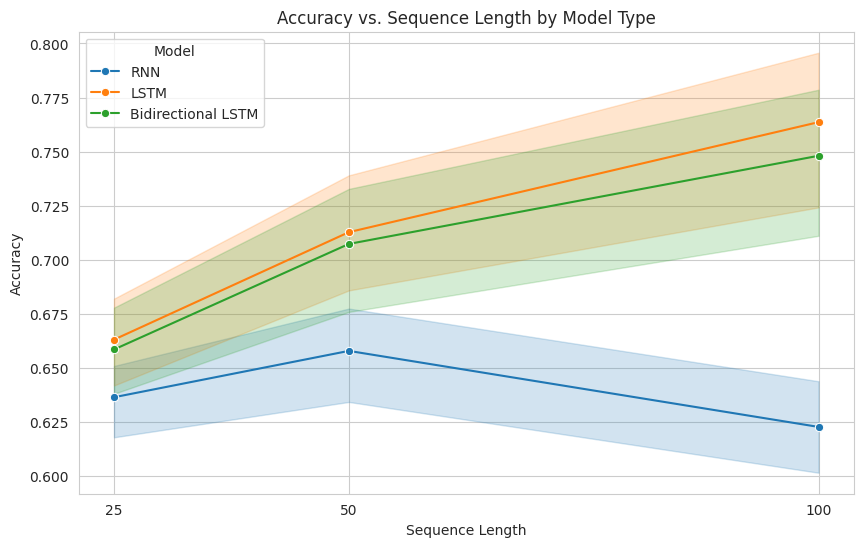

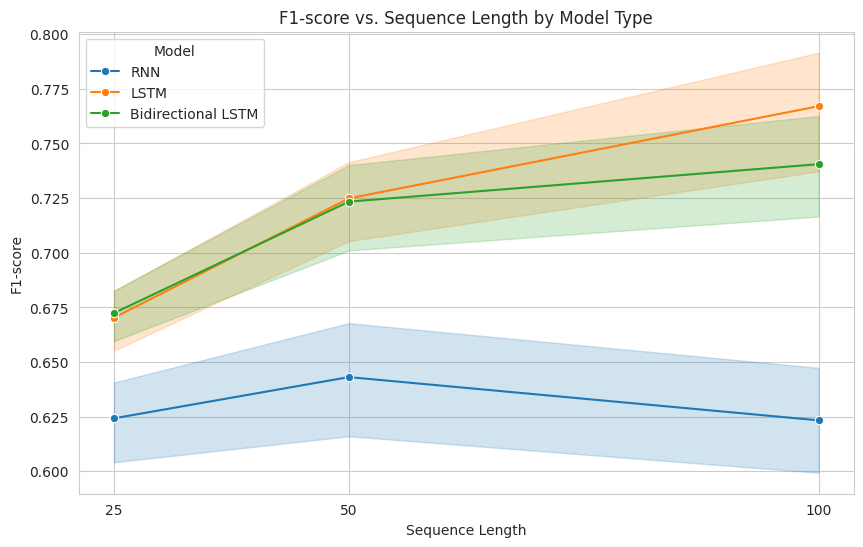

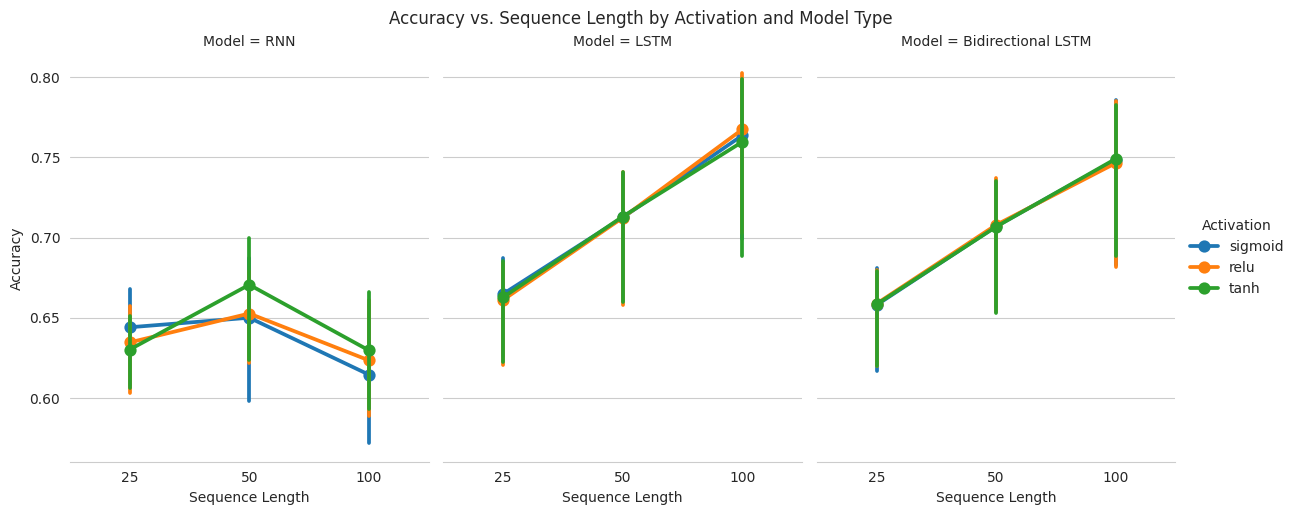

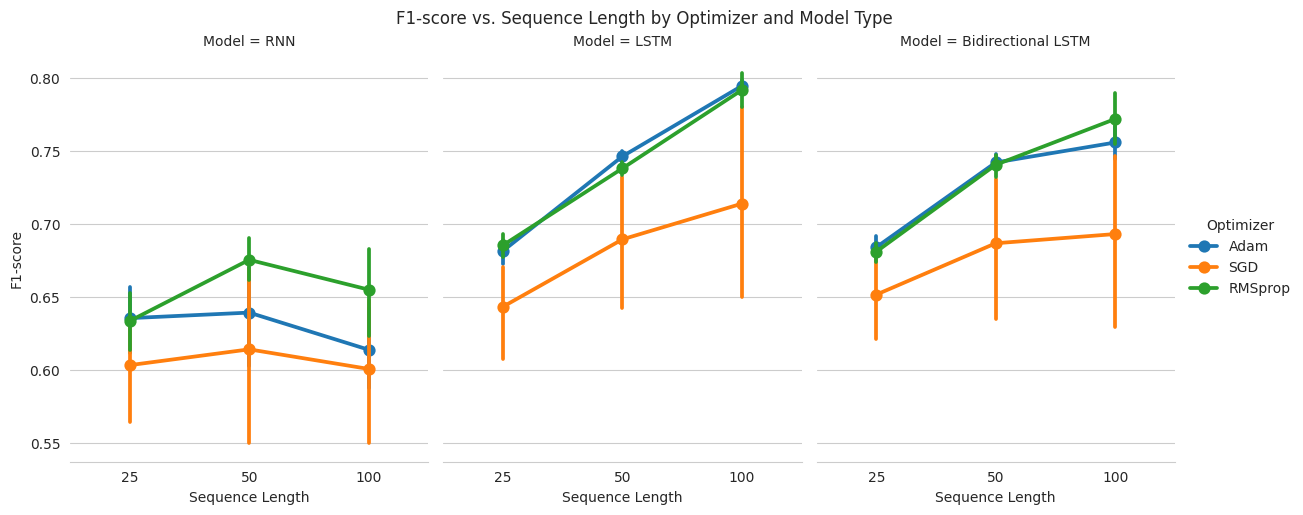

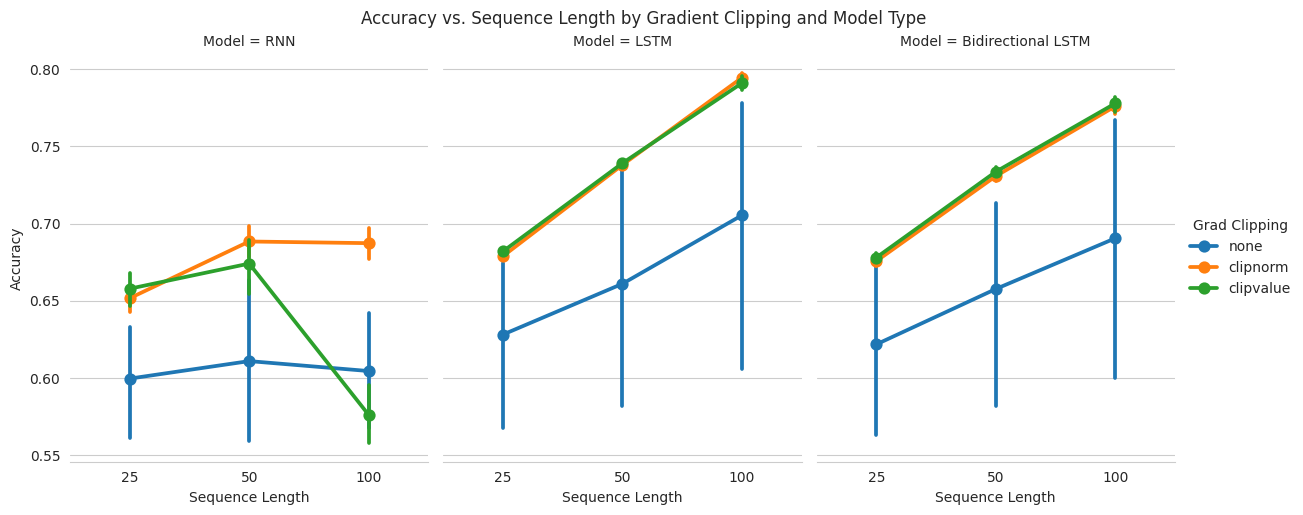

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Plot Accuracy vs. Seq Length, colored by Model
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Seq Length', y='Accuracy', hue='Model', marker='o')
plt.title('Accuracy vs. Sequence Length by Model Type')
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.xticks(parameter_grid['sequence_length'])
plt.legend(title='Model')
plt.grid(True)
plt.show()

# Plot F1-score vs. Seq Length, colored by Model
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Seq Length', y='F1-score', hue='Model', marker='o')
plt.title('F1-score vs. Sequence Length by Model Type')
plt.xlabel('Sequence Length')
plt.ylabel('F1-score')
plt.xticks(parameter_grid['sequence_length'])
plt.legend(title='Model')
plt.grid(True)
plt.show()

# Explore impact of Activation on Accuracy across sequence lengths using faceting
g = sns.catplot(data=results_df, x='Seq Length', y='Accuracy', hue='Activation', col='Model', kind='point', height=5, aspect=.8)
g.fig.suptitle('Accuracy vs. Sequence Length by Activation and Model Type', y=1.02)
g.set_axis_labels("Sequence Length", "Accuracy")
g.set_xticklabels(parameter_grid['sequence_length'])
g.despine(left=True)
plt.show()

# Explore impact of Optimizer on F1-score across sequence lengths using faceting
g = sns.catplot(data=results_df, x='Seq Length', y='F1-score', hue='Optimizer', col='Model', kind='point', height=5, aspect=.8)
g.fig.suptitle('F1-score vs. Sequence Length by Optimizer and Model Type', y=1.02)
g.set_axis_labels("Sequence Length", "F1-score")
g.set_xticklabels(parameter_grid['sequence_length'])
g.despine(left=True)
plt.show()

# Explore impact of Grad Clipping on Accuracy across sequence lengths using faceting
g = sns.catplot(data=results_df, x='Seq Length', y='Accuracy', hue='Grad Clipping', col='Model', kind='point', height=5, aspect=.8)
g.fig.suptitle('Accuracy vs. Sequence Length by Gradient Clipping and Model Type', y=1.02)
g.set_axis_labels("Sequence Length", "Accuracy")
g.set_xticklabels(parameter_grid['sequence_length'])
g.despine(left=True)
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Data Preprocessing:** The IMDb dataset was successfully loaded, preprocessed by lowercasing and removing punctuation, tokenized, filtered to the top 10,000 words, and converted into sequences. Sequences were then padded or truncated to lengths of 25, 50, and 100.
*   **Model Building:** Functions were successfully implemented to build Simple RNN, LSTM, and Bidirectional LSTM models with configurable activation functions, optimizers, dropout, and optional gradient clipping (by norm or value).
*   **Experimental Setup:** A comprehensive set of 243 experiments was conducted, covering all combinations of model type (RNN, LSTM, Bidirectional LSTM), activation function (sigmoid, relu, tanh), optimizer (Adam, SGD, RMSprop), sequence length (25, 50, 100), and gradient clipping strategy (none, clipnorm, clipvalue).
*   **Performance Evaluation:** For each experiment, models were trained for 5 epochs, and performance was evaluated on the test set using Accuracy and F1-score. The training time per epoch was also recorded.
*   **Result Summarization:** All experimental results, including model configurations, Accuracy, F1-score, and Epoch Time, were compiled into a structured pandas DataFrame.
*   **Visualization:** Plots were generated to visualize the relationships between Sequence Length and performance metrics (Accuracy and F1-score), faceted by Model type, Activation function, Optimizer, and Gradient Clipping strategy.

### Insights or Next Steps

*   Analyze the generated plots and summary table to identify the best performing combinations of hyperparameters and understand the impact of each factor (architecture, activation, optimizer, sequence length, gradient clipping) on model performance and training efficiency.
*   Based on the analysis, select the most promising configurations for further tuning (e.g., exploring different learning rates, dropout rates, or number of units) or longer training durations to potentially achieve higher performance.
